In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8s4v_xfn because the default path (/home/mi/marcelli/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Problem 8: Widom’s Test Particle Insertion Method 

Widom’s test particle insertion is a powerful method to estimate the excess chemical potential $\mu^{\text{ex}}$ of a fluid from equilibrium configurations.  

The key idea is that instead of running a grand-canonical simulation, one can compute the probability cost of inserting an extra particle into an existing system by sampling the Boltzmann factor of the insertion energy.

The excess chemical potential is defined via:

$$
\mu^{\text{ex}} = -k_B T \ln \left\langle \exp(-\beta \Delta U) \right\rangle
$$

where:

- $k_B$ is the Boltzmann constant
- $T$ is the temperature
- $\beta = 1/(k_B T)$
- $\Delta U$ is the potential energy change caused by inserting a test particle at a random location


Imagine we try to insert an extra particle at a random position in the system:

- If the local environment is dense (high overlap), $\Delta U$ is very large and $\exp(-\beta \Delta U)$ is nearly zero.
- If the local environment is favorable (low overlap), $\exp(-\beta \Delta U)$ contributes more.

Averaging these Boltzmann factors over many insertions and many independent configurations allows us to estimate the free energy cost of adding a particle.

#### Algorithm Steps

**Prepare Configurations**  
- Run an NVT molecular dynamics simulation to generate *independent* equilibrium snapshots.
- For periodic boundary conditions, *unwrap* coordinates using box images and then *wrap* them back into the primary box:

$$
\mathbf{r}_i^{\text{wrapped}} = (\mathbf{r}_i^{\text{unwrapped}}) \bmod L
$$

**Perform M Random Insertions per Configuration**  
- For each insertion:
  - Sample a test particle position uniformly in $[0, L)^3$:

$$
\mathbf{r}_{\text{insert}} \sim \text{Uniform}(0, L)
$$

  - Compute separations to all N particles, applying **minimum image convention**:

$$
\mathbf{r}_{ij} = \mathbf{r}_i - \mathbf{r}_{\text{insert}} - L \cdot \text{nint}\left(\frac{\mathbf{r}_i - \mathbf{r}_{\text{insert}}}{L}\right)
$$

  - Compute pairwise Lennard-Jones energies:

$$
u(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

  - Sum over all interactions to get $\Delta U$:

$$
\Delta U = \sum_{i=1}^{N} u(|\mathbf{r}_{ij}|)
$$

  - Store $\exp(-\beta \Delta U)$.

**Average over Insertions and Configurations**  
- Collect all values of $\exp(-\beta \Delta U)$ from all configurations.
- Compute the sample average:

$$
\left\langle \exp(-\beta \Delta U) \right\rangle \approx \frac{1}{M_{\text{total}}} \sum_{k=1}^{M_{\text{total}}} \exp(-\beta \Delta U_k)
$$

**Estimate Excess Chemical Potential**  
- Use:

$$
\mu^{\text{ex}} = -k_B T \ln \left\langle \exp(-\beta \Delta U) \right\rangle
$$

- Also estimate the **standard error** via standard deviation:

$$
\sigma_{\mu} \approx \frac{\text{Std}\left[\exp(-\beta \Delta U)\right]}{\sqrt{M_{\text{total}}} \left\langle \exp(-\beta \Delta U) \right\rangle} \cdot k_B T
$$

#####  Implementation Notes

- Positions **must** be wrapped into the primary simulation box before insertions, or minimum image calculations will be wrong.
- Periodic boundary conditions are handled using the **minimum image convention**.
- Sampling over many independent configurations improves statistical convergence.
- The number of insertions $M$ per configuration can be increased until desired precision (e.g., 10% relative error) is achieved.

In [2]:
with h5py.File("problem08.h5", "r") as f:
    positions = np.array(f["/particles/all/position/value"]) # shape = (n_frames, 64, 3)
    box_length = np.diagonal(f["/particles/all/box/edges"])
    images = np.array(f["particles/all/image/value"])

    # Unwrap and recenter positions
    positions -= box_length * images
    positions += box_length / 2

print("Loaded configurations:", positions.shape)
print("Box lenght:", box_length)

Loaded configurations: (51, 64, 3)
Box lenght: [6. 6. 6.]


In [3]:
def widom_insertion(config, box_length, beta, M, epsilon=1.0, sigma=1.0):
    N = config.shape[0]
    samples = []
    
    for _ in range(M):
        r_insert = np.random.uniform(0, box_length, 3)
        rij = config - r_insert
        rij -= box_length * np.round(rij / box_length)
        dist2 = np.sum(rij**2, axis=1)
        inv_r6 = (sigma**2 / dist2)**3
        lj_energy = 4 * epsilon * (inv_r6**2 - inv_r6)
        delta_U = np.sum(lj_energy)
        samples.append(np.exp(-beta * delta_U))
        
    return np.array(samples)

def estimate_mu_ex(all_samples, beta):
    mean_B = np.mean(all_samples)
    stderr_B = np.std(all_samples, ddof=1) / np.sqrt(len(all_samples))
    mu_ex = -np.log(mean_B) / beta
    mu_ex_err = stderr_B / mean_B / beta
    return mu_ex, mu_ex_err

beta = 1 / 1.5
k_values = [1, 2, 5, 7]
results = []

for k in k_values:
    M = 10 ** k
    print(f"\n Testing k={k}, M={M}")
    all_exp_samples = []

    for config in tqdm(positions):
        all_exp_samples.extend(widom_insertion(config, box_length, beta, M))
    
    all_exp_samples = np.array(all_exp_samples)
    mu_ex, mu_ex_err = estimate_mu_ex(all_exp_samples, beta)
    relative_error = mu_ex_err / abs(mu_ex)
    
    print(f"μ_ex = {mu_ex:.4f} ± {mu_ex_err:.4f} (relative error = {relative_error:.2%})")
    results.append((k, M, mu_ex, mu_ex_err, relative_error))



 Testing k=1, M=10


100%|██████████| 51/51 [00:00<00:00, 1679.64it/s]


μ_ex = -1.4742 ± 0.1662 (relative error = 11.28%)

 Testing k=2, M=100


100%|██████████| 51/51 [00:00<00:00, 180.54it/s]


μ_ex = -1.5751 ± 0.0540 (relative error = 3.43%)

 Testing k=5, M=100000


100%|██████████| 51/51 [04:10<00:00,  4.92s/it]


μ_ex = -1.5762 ± 0.0017 (relative error = 0.11%)

 Testing k=7, M=10000000


100%|██████████| 51/51 [6:31:16<00:00, 460.32s/it]  


μ_ex = -1.5762 ± 0.0002 (relative error = 0.01%)



Summary:
k   M        mu_ex       error       rel_error
1   10        -1.4742  ± 0.1662   (11.28%)
2   100       -1.5751  ± 0.0540   (3.43%)
5   100000    -1.5762  ± 0.0017   (0.11%)
7   10000000  -1.5762  ± 0.0002   (0.01%)


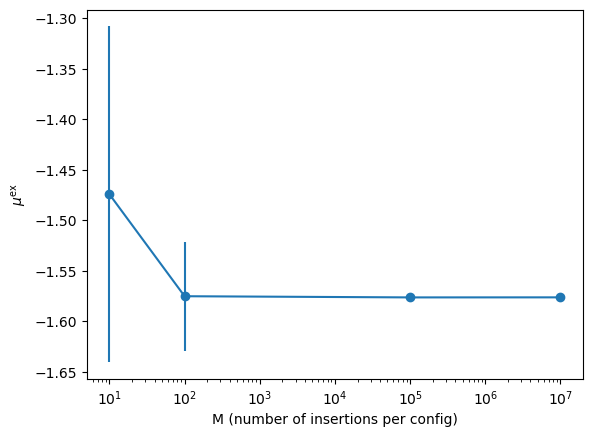

In [4]:
print("\nSummary:")
print("k   M        mu_ex       error       rel_error")
for k, M, mu, err, rel in results:
    print(f"{k:<3} {M:<9} {mu:.4f}  ± {err:.4f}   ({rel:.2%})")

ks, Ms, mus, errs, rels = zip(*results)
plt.errorbar(Ms, mus, yerr=errs, fmt='o-')
plt.xscale('log')
plt.xlabel('M (number of insertions per config)')
plt.ylabel(r'$\mu^{\mathrm{ex}}$')
plt.show()
